# Global registration with RANSAC
We are going to use [open3d](http://www.open3d.org/) to handle point clouds and generation of point clouds
We are importing the packages and defining a function which helps us drawing the point clouds.

In [9]:
import open3d as o3d
import numpy as np
import copy

def draw_registrations(source, target, transformation=None, recolor=False, max_points=100000):
    """
    Visualizes the source and target point clouds with an optional transformation and recoloring.

    Parameters:
    - source (o3d.geometry.PointCloud): The source point cloud.
    - target (o3d.geometry.PointCloud): The target point cloud.
    - transformation (numpy.ndarray, optional): 4x4 transformation matrix to apply to the source.
    - recolor (bool, optional): If True, apply distinct colors to source and target.
    - max_points (int, optional): Maximum number of points to visualize for each point cloud.
    """
    # Create copies to avoid modifying the original point clouds
    source_temp = source.copy()
    target_temp = target.copy()
    
    # Downsample for visualization if necessary
    if len(source_temp.points) > max_points:
        source_temp = source_temp.uniform_down_sample(every_k_points=int(len(source_temp.points) / max_points))
    if len(target_temp.points) > max_points:
        target_temp = target_temp.uniform_down_sample(every_k_points=int(len(target_temp.points) / max_points))
    
    # Apply recoloring if requested
    if recolor:
        # Paint source and target with distinct colors
        source_temp.paint_uniform_color([1, 0.706, 0])    # Orange
        target_temp.paint_uniform_color([0, 0.651, 0.929])  # Blue
    
    # Apply transformation if provided
    if transformation is not None:
        source_temp.transform(transformation)
    
    # Use Open3D's newer visualization for better compatibility
    try:
        o3d.visualization.draw_geometries([source_temp, target_temp],
                                          window_name="Registration",
                                          width=800,
                                          height=600,
                                          left=50,
                                          top=50,
                                          point_show_normal=False)
    except Exception as e:
        print(f"Visualization Error: {e}")


We need to read in our pointclouds. For that we use the `io` module of the
open3d package (`o3d`). The following cell will open a window with a
visualization of both point clouds `source` and `target`.

Also, this page [Visualization - Open3D](http://open3d.org/html/tutorial/Basic/visualization.html)
contains some useful examples and instructions on how to use the viewer.

In [10]:
source = o3d.io.read_point_cloud("ICP/r1.pcd")
target = o3d.io.read_point_cloud("ICP/r2.pcd")

# Used for downsampling.
voxel_size = 0.05

# Show models side by side
draw_registrations(source, target, recolor = False)

AttributeError: 'open3d.cpu.pybind.geometry.PointCloud' object has no attribute 'copy'

### Finding features in pointclouds
When working on point clouds it can be beneficial to work on a downsampled version of the point cloud,
as it decreases the need of computation.

You can use [`pointcloud.voxel_down_sample()`](http://www.open3d.org/docs/latest/python_api/open3d.geometry.PointCloud.html#open3d.geometry.PointCloud.voxel_down_sample) where `pointcloud` is the name of your point cloud object. In our case, that would be `source` and `target`.

We also need to estimate the normals of the point cloud points using [`pointcloud.estimate_normals()`](http://www.open3d.org/docs/latest/python_api/open3d.geometry.PointCloud.html#open3d.geometry.PointCloud.voxel_down_sample)

**Task:** Find FPFH features or correspondances of the downsampled point clouds.
[`o3d.pipelines.registration.compute_fpfh_feature()`](http://www.open3d.org/docs/latest/python_api/open3d.pipelines.registration.compute_fpfh_feature.html)


In [3]:
####
# Downsample and find features here
####

# Downsample
source_down = source.voxel_down_sample(voxel_size)
target_down = target.voxel_down_sample(voxel_size)

# Compute normals
source_down.estimate_normals(
    o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

target_down.estimate_normals(
    o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Compute FPFH features
source_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
    source_down,
    o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=100))

target_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
    target_down,
    o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=100))


In [4]:
# Draw downsamples
draw_registrations(source_down, target_down)

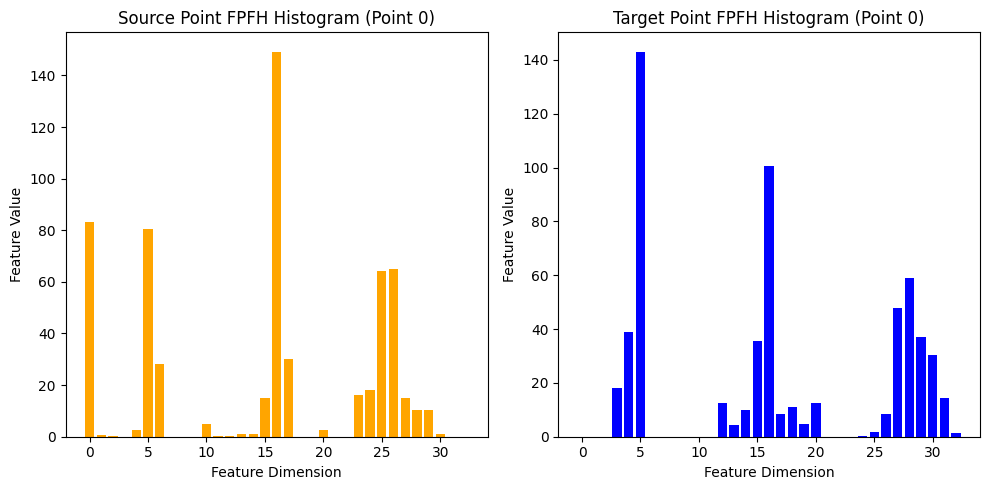

In [5]:
import matplotlib.pyplot as plt

# Select an index to visualize
index = 0  # Choose a point (0 to len(source_down.points)-1)

# Extract the FPFH feature for the selected point
source_fpfh_hist = source_fpfh.data[:, index]
target_fpfh_hist = target_fpfh.data[:, index]

# Plot the FPFH histogram for the selected point from both source and target
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(range(len(source_fpfh_hist)), source_fpfh_hist, color='orange')
plt.title(f"Source Point FPFH Histogram (Point {index})")
plt.xlabel('Feature Dimension')
plt.ylabel('Feature Value')

plt.subplot(1, 2, 2)
plt.bar(range(len(target_fpfh_hist)), target_fpfh_hist, color='blue')
plt.title(f"Target Point FPFH Histogram (Point {index})")
plt.xlabel('Feature Dimension')
plt.ylabel('Feature Value')

plt.tight_layout()
plt.show()


In [6]:
import open3d as o3d
import numpy as np

# Pick a specific FPFH dimension (e.g., dimension 0)
fpfh_dimension = 16

# Normalize the FPFH values to a range between 0 and 1
source_fpfh_values = source_fpfh.data[fpfh_dimension, :]
source_fpfh_values_normalized = (source_fpfh_values - np.min(source_fpfh_values)) / (np.max(source_fpfh_values) - np.min(source_fpfh_values))

# Convert FPFH values to RGB colors (e.g., shades of blue)
source_colors = np.zeros((len(source_fpfh_values), 3))  # Initialize as black
source_colors[:, 2] = source_fpfh_values_normalized  # Blue color channel is set based on FPFH values

# Assign the colors to the source point cloud
source_down.colors = o3d.utility.Vector3dVector(source_colors)

# Visualize the colored point cloud
# o3d.visualization.draw_geometries([source_down], window_name="FPFH Color-Coded Source Cloud")


### RANSAC 
We will now attempt to use RANSAC to do a global registration of the two point clouds.

By using the function [`o3d.pipelines.registration.registration_ransac_based_on_feature_matching`](http://www.open3d.org/docs/latest/python_api/open3d.pipelines.registration.registration_ransac_based_on_feature_matching.html) from open3d, do the following:


Try to find the transformation from `r1.pcd` (`source`) to `r2.pcd` (`target`).
Attempt with point-to-point and point-to-plane
```Python
point_to_point =  o3d.pipelines.registration.TransformationEstimationPointToPoint(False)
point_to_plane =  o3d.pipelines.registration.TransformationEstimationPointToPlane()
```

When using RANSAC, focus on the arguments below. The rest are optional parameters.
```Python
ransac_result = o3d.registration.registration_ransac_based_on_feature_matching(
    source_sample, target_sample, 
    source_fpfh, target_fpfh, 
    distance_threshold,
    point_to_point)
```

In [7]:
import open3d as o3d
import numpy as np

# Define RANSAC parameters
distance_threshold = voxel_size * 1.5  # Adjust factor as needed

# Define transformation estimation methods
point_to_point = o3d.pipelines.registration.TransformationEstimationPointToPoint(False)
point_to_plane = o3d.pipelines.registration.TransformationEstimationPointToPlane()

# Define convergence criteria with reduced iterations and appropriate confidence
ransac_criteria = o3d.pipelines.registration.RANSACConvergenceCriteria(
    max_iteration=100000,  # Reduced from 4,000,000 to prevent kernel crash
    confidence=0.999        # Default value; adjust if needed
)

# Perform RANSAC registration using point-to-point
ransac_result_p2p = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
    source_down, target_down, 
    source_fpfh, target_fpfh, 
    mutual_filter=True,
    max_correspondence_distance=distance_threshold,
    estimation_method=point_to_point,
    ransac_n=4,  # Number of points to sample for generating a pose
    checkers=[
        o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
        o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)
    ],
    criteria=ransac_criteria
)

## Exercises
### A)
Can you get a decent transformation from r1 to r3? (check the ICP folder)
### B)
With the following checkers, can you get better results from RANSAC? Try tweaking the parameters of them. Can you make point-to-plane work? Do not spend too much time on this, if you can't manage, skip it. (I was not able to get a good fit.)

You can also try tweaking the `voxel_size`

```Python
corr_length = 0.9
distance_threshold = voxel_size * 1.5

c0 = o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(corr_length)
c1 = o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)
c2 = o3d.pipelines.registration.CorrespondenceCheckerBasedOnNormal(0.095)

checker_list = [c0,c1,c2]

ransac_result = o3d.registration.registration_ransac_based_on_feature_matching(
    source_sample, target_sample, 
    source_fpfh, target_fpfh, 
    True,
    distance_threshold,
    point_to_point,
    checkers = checker_list)
```
